<img src="https://heig-vd.ch/docs/default-source/doc-global-newsletter/2020-slim.svg" alt="Logo HEIG-VD" style="width: 80px;" align="right"/>

# Cours APN - Labo 7 : Classification non supervisée

## Résumé
Le but de ce laboratoire est de réaliser une expérience de classification non-supervisée d'articles.  L'approche se base sur des vecteurs en basse dimension (*embeddings*) qui représentent les classes, qui seront comparés avec les vecteurs en basse dimension (*embeddings*) représentant les documents.  Ces *embeddings* seront obtenus soit grâce au modèle `word2vec`.  La méthode sera testée sur un corpus d'articles provenant de rubriques connues, ce qui permettra d'évaluer les méthodes.

In [129]:
# Librairies générales
import pandas as pd
import numpy as np
import random
from tqdm import tqdm

In [130]:
# Similarité entre vecteurs (mots, catégories ou textes)
from sklearn.metrics.pairwise import cosine_similarity

In [131]:
# Librairies pour l'évaluation
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score

## 1. Préparation des données

Vous utiliserez un corpus d'environ 200'000 articles (titres et résumés) [diponibles sur Kaggle](https://www.kaggle.com/datasets/rmisra/news-category-dataset/versions/2) (V2, 80 Mo, nécessite un login) mais dont une copie est **fournie sur Cyberlearn**.  Dans cette partie, vous allez:
  - a. charger le corpus fourni au format JSON, l'explorer et afficher des statistiques
  - b. définir une fonction de normalisation de textes (avec la librairie `utils.py` déjà utilisée)
  - c. définir une fonction d'extraction des textes avec leur catégorie
***

**a.** Veuillez charger le corpus à l'aide des instructions données ci-dessous, puis afficher les statistiques suivantes :
  * un exemple d'article
  * nombre total d'articles
  * nombre d'articles pour chaque catégorie (ou classe) par ordre décroissant
  * nombre d'articles sans `headline`
  * nombre d'articles sans `short_description`
  * nombre d'articles dont la longueur de `headline + short_description` est inférieure ou égale à 2 caractères
  * longueur moyenne de `headline + short_description`

In [132]:
import json
from collections import Counter # pour calculer facilement le nombre d'articles par categorie

In [133]:
corpus  = []
with open('News_Category_Dataset_v2.json', mode='r', errors='ignore') as json_file:
    for dic in json_file:
        corpus.append(json.loads(dic))

In [134]:
print(f"Exemple d'article: {corpus[31]}")

print(f"Nombre total d'articles: {len(corpus)}")

print(f"""Nombre d'article par catégorie: {Counter([c["category"] for c in corpus])}""")

print(f"""Nombre d'articles sans headline: {Counter([c["headline"] == "" for c in corpus])[True]}""")

print(f"""Nonbre d'articles sans short_description: {Counter([c["short_description"] == "" for c in corpus])[True]}""")

print(f"""Nombre d'articles dont la longueur de headline + short_description est inférieure ou égale à 2 caractères: {Counter([len(c["headline"] + c["short_description"]) <= 2 for c in corpus])[True]}""")

print(f"""Longueur moyenne de headline + short_description: {np.mean([len(c["headline"] + c["short_description"]) for c in corpus], dtype=int)}""")

Exemple d'article: {'category': 'BLACK VOICES', 'headline': 'BET Chairman and CEO Debra Lee Is Stepping Down', 'authors': 'Carla Baranauckas', 'link': 'https://www.huffingtonpost.com/entry/bet-ceo-stepping-down-debra-lee_us_5b071754e4b07c4ea1066888', 'short_description': 'Lee brought more original shows to the black entertainment network and focused on family programming.', 'date': '2018-05-25'}
Nombre total d'articles: 200853
Nombre d'article par catégorie: Counter({'POLITICS': 32739, 'WELLNESS': 17827, 'ENTERTAINMENT': 16058, 'TRAVEL': 9887, 'STYLE & BEAUTY': 9649, 'PARENTING': 8677, 'HEALTHY LIVING': 6694, 'QUEER VOICES': 6314, 'FOOD & DRINK': 6226, 'BUSINESS': 5937, 'COMEDY': 5175, 'SPORTS': 4884, 'BLACK VOICES': 4528, 'HOME & LIVING': 4195, 'PARENTS': 3955, 'THE WORLDPOST': 3664, 'WEDDINGS': 3651, 'WOMEN': 3490, 'IMPACT': 3459, 'DIVORCE': 3426, 'CRIME': 3405, 'MEDIA': 2815, 'WEIRD NEWS': 2670, 'GREEN': 2622, 'WORLDPOST': 2579, 'RELIGION': 2556, 'STYLE': 2254, 'SCIENCE': 2178, 'WOR

**b.** Veuillez définir une fonction de nettoyage et normalisation des textes, qui vise à réduire la diversité du vocabulaire (lemmatisation, suppression des ponctuations, nombres, ou *stopwords*, etc.).  Veuillez utiliser les fonctions fournies dans la librairie `utils.py` fournie sur Cyberlearn et déjà vue au labo 3 (groupement hiérarchique de films).  Votre fonction devra prendre en entrée un texte non-tokenisé (une chaîne de caractères) et retournera un texte non-tokenisé.

In [135]:
import utils # fonctions de pré-traitement des textes

In [136]:
def normalize_text(text):
    text = utils.remove_punctuation(text)
    text = utils.remove_stopwords(text)
    text = utils.remove_non_alphabetic(text)
    text = utils.lemmatize_text(text)
    return text

In [137]:
print(f"""Avant traitement: {corpus[2024]["short_description"]}""")
print(f"""Après traitement: {normalize_text(corpus[2024]["short_description"])}""")

Avant traitement: “I’m unwilling to take no for an answer, I’m gonna make it law by executive order."
Après traitement: i unwilling take answer i gon na law executive order


**c.** Veuillez écrire une fonction qui sélectionne les articles d'une ou plusieurs catégories (données sous forme de liste, p.ex. `['MONEY', 'SCIENCE']`) et retourne leurs textes et leurs catégories.  Plus précisément :
* la fonction retourne une liste de textes et une liste de catégories de même longueur (au texte *i* correspond la catégorie ou classe *i*)
* le texte de chaque article est composé de son `headline` et de sa `short_description`, séparés par un point+espace
* si `normalize=True`, la fonction normalise les textes (note : ça ne sera pas toujours souhaitable dans les expériences suivantes)
* on ne retient dans le résultat que les textes dont la longueur finale est supérieure à 3 caractères.

In [138]:
def select_texts_categories(corpus, selected_categories, normalize=True):
    texts = []
    categories = []

    for article in tqdm(corpus):
        if article["category"] in selected_categories:
            text = article["headline"] + ". " + article["short_description"]
            
            texts.append(normalize_text(text) if normalize else text)
            categories.append(article["category"])
            
    return texts, categories

**d.** Veuillez exécuter la fonction, en appliquant la normalisation des textes, puis afficher un exemple de résultat et commenter brièvement son contenu.  Le code est donné ci-dessous, et vous devez ajouter votre commentaire.

In [139]:
selected_categories = ['MONEY', 'SCIENCE']
texts, categories = select_texts_categories(corpus, selected_categories, normalize=True)
print("Exemple :", categories[142], ':', texts[142])

100%|██████████| 200853/200853 [00:06<00:00, 29102.37it/s]

Exemple : SCIENCE : fireball rip through siberian sky in brilliant display of light frankly i scar i think bomb witness say


**Réponse**: La _headline_ est un peu plus compréhensible (et plus proche du texte non-normalisé) que la description courte. L'utilisation de _scar_ à la place de _scared_ du texte original pourrait porter à confusion et ne donne pas la même information (j'ai été blessé _vs_ j'ai eu peur).

___
## 2. Classification non supervisée avec des embeddings word2vec

La méthode de classification proposée comporte trois étapes.  Le but de cette partie est de définir une fonction pour chacune d'elles.  Au début, une (re)prise en main de word2vec est demandée.
* a. prise en main de word2vec
* b. création des représentations vectorielles (*embeddings*) des classes (catégories)
* c. création des représentations vectorielles (*embeddings*) d'un texte
* d. classification : comparer les similarités du vecteur de texte avec les vecteurs des classes, choisir la plus similaire
___

**a.** Prise en main de word2vec.  Vous avez déjà utilisé word2vec au Labo 4 sur la visualisation de vecteurs de mots (et Cémantix) mais ici vous utiliserez un modèle pour l'anglais.  Vous pouvez consulter la [documentation de gensim sur KeyedVectors](https://radimrehurek.com/gensim/models/keyedvectors.html#what-can-i-do-with-word-vectors)). 

In [140]:
import gensim
from gensim.models import KeyedVectors

In [141]:
# Si le modèle n'est pas téléchargé :
#w2v_model = gensim.downloader.load('word2vec-google-news-300')
# S'il l'est déjà, indiquer son emplacement :
path_to_model = "C:\\Users\\hugo\\code\\heig\\apn\\APN_L7\\word2vec-google-news-300.gz"
w2v_model = KeyedVectors.load_word2vec_format(path_to_model, binary=True)
# Attention, ce modèle prend environ 5 Go en mémoire. 

Veuillez afficher les mots les plus similaires selon ce modèle word2vec du mot 'science'.  Même question pour le mot 'money' (ce sont des noms de catégories).  Que pensez-vous du résultat ?  

In [142]:
print("science:")
print(w2v_model.most_similar("science"))

print("money:")
print(w2v_model.most_similar("money"))

science:
[('faith_Jezierski', 0.6965422034263611), ('sciences', 0.6821076273918152), ('biology', 0.6775783896446228), ('scientific', 0.6535001993179321), ('mathematics', 0.6300910115242004), ('Hilal_Khashan_professor', 0.6153368353843689), ('impeach_USADA', 0.6149060130119324), ('professor_Kent_Redfield', 0.6144178509712219), ('physics_astronomy', 0.6105074882507324), ('bionic_prosthetic_fingers', 0.6083078980445862)]
money:
[('monies', 0.7165061831474304), ('funds', 0.7055202722549438), ('moneys', 0.6289054751396179), ('dollars', 0.628852367401123), ('cash', 0.6151221394538879), ('vast_sums', 0.6057385802268982), ('fund', 0.5789709091186523), ('Money', 0.5733489394187927), ('taxpayer_dollars', 0.5693671107292175), ('Monies', 0.5586517453193665)]


**Réponse**: Certains mots donnés comme similaires à _science_, p.ex _faith_Jezierski_, _Hilal_Khashan_professor_, etc. ne sont pas vraiments des noms communs mais plutôt des noms de personnes. Ils sont probablement issus de la littérature scientifique ingérée par le modèle où le mot _science_ devait lui même être très présent également et a été associé à ces noms là.

Pour _money_, les résultats sont plus conventionnels bien que l'on peut noter la redondance du terme _monies_ avec et sans majuscule, ainsi que la présence de termes à plusieurs mots comme par exemple _taxpayer_dollars_ ou _vasts_sums_.

Basé sur les résultats précédents et vos intuitions sur les articles qu'on peut trouver dans les catégories `['SCIENCE', 'MONEY']`, veuillez indiquer ici 5 à 10 mots représentatifs de chacune de ces deux catégories.

**Réponse**:

_science_: _biology_, _mathematics_, _physics_, _meteorology_, _astronomy_

_money_: _dollar_, _cash_, _fund_, _taxpayer_, _sum_

**b.** Création des représentations vectorielles des classes (catégories).

Veuillez définir une fonction qui retourne un vecteur (*embedding*) word2vec pour chacune des classes d'un tableau qui est fourni en argument de la fonction.  Consignes :

* la fonction retourne la moyenne des *embeddings* des mots-clés associés à chaque classe;
* pour les classes 'SCIENCE' et 'MONEY', elle prend les mots-clés que vous avez choisis ci-dessus (au (a)) ;
* pour les autres classes, elle demande à word2vec les `topn` voisins du nom de la classe (en minuscules) ;
  - si `topn = 0`, on utilise seulement le nom de la classe (en minuscules) ;
  - on suppose que le nom de la classe est connu de word2vec.


In [143]:
def cat_embedding_w2v(model, category_names, topn=30):
    science_kw = ["biology", "mathematics", "physics", "meteorology", "astronomy"]
    money_kw = ["dollar", "cash", "fund", "taxpayer", "sum"]

    category_embeddings = []

    for category in category_names:
        words = []
        match category:
            case "SCIENCE":
                words = science_kw
            case "MONEY":
                words = money_kw
            case _:
                words = np.array(model.most_similar(category.lower(), topn))[:, 0] if topn > 0 else [category.lower()]

        category_embeddings.append(np.mean([model.get_vector(kw) for kw in words], axis=0))

    return np.array(category_embeddings)

In [144]:
# Test : affiche-t-on 'True' ?
e1 = cat_embedding_w2v(w2v_model, ['SCIENCE'], topn=30)
e2 = cat_embedding_w2v(w2v_model, ['TECH'],    topn=30)
e3 = cat_embedding_w2v(w2v_model, ['TASTE'],   topn=30)
cosine_similarity(e1, e2) > cosine_similarity(e2, e3)

array([[ True]])

**c.** Création de la représentation vectorielle d'un texte

Veuillez définir une fonction qui prend un texte (*string*) en argument et retourne un vecteur (*embedding*) qui représente le texte.  Le texte doit être découpé en mots (tokenisé), puis on doit tester si chaque mot est connu du modèle word2vec, et si oui, on récupère le *embedding* du mot.  La fonction retourne la moyenne des *embeddings*, sauf si aucun mot du texte n'est connu du modèle word2vec, auquel cas elle retourne `[]`.

In [145]:
from nltk import word_tokenize

In [146]:
def text_embedding_w2v(model, text):
    embedding = []
    for token in word_tokenize(text):
        if model.has_index_for(token):
            embedding.append(model.get_vector(token))

    return embedding if len(embedding) == 0 else np.mean(embedding, axis=0)

**d.** Classification non supervisée d'articles avec word2vec

Veuillez définir une fonction qui prend en entrée :
* un modèle word2vec
* une liste de textes à classifier
* une liste de catégories définies par leur nom en majuscules (p.ex. `['SCIENCE', 'MONEY']`)
et qui retourne le tableau avec la catégorie prédite pour chaque texte parmi les catégories données.  

Pour prédire la catégorie, la fonction calcule la similarité cosinus du *embedding* du texte avec chacun des *embeddings* des catégories, et choisit la catégorie qui a la plus grande similarité.  Si le texte n'a pas de *embedding* (parce qu'aucun de ses mots n'est connu du modèle), ou si plusieurs catégories ont la même similarité, on tire au sort la catégorie.

In [147]:
def classify_w2v(model, texts, selected_categories, topn = 30):
    cat_embeddings = cat_embedding_w2v(model, selected_categories, topn=topn)
    cat_pred = []

    for text in tqdm(texts):
        text_embedding = text_embedding_w2v(model, text) # cosine_similarity nécéssite deux dimensions
        if len(text_embedding) == 0:
            cat_pred.append(np.random.choice(selected_categories))
            continue
        else:
            text_embedding = np.array([text_embedding])
            
        similarities = cosine_similarity(text_embedding, cat_embeddings)
        cat_pred.append(selected_categories[np.argmax(similarities)])

    return cat_pred

**e.** Veuillez réaliser la classification non supervisée des articles des catégories `['SCIENCE', 'MONEY']`.  Afficher les scores obtenus et la matrice de confusion en utilisant les fonctions de `sklearn.metrics` importées au début du notebook.  Veuillez faire plusieurs essais pour optimiser les fonctions et leurs appels, et à la fin laisser votre meilleur résultat dans ce notebook.  

In [148]:
selected_categories = ['SCIENCE', 'MONEY']
selected_texts = select_texts_categories(corpus, selected_categories=selected_categories, normalize=True)

100%|██████████| 200853/200853 [00:06<00:00, 29372.68it/s]


100%|██████████| 3885/3885 [00:01<00:00, 2433.49it/s]


              precision    recall  f1-score   support

       MONEY       0.66      0.99      0.79      1707
     SCIENCE       0.98      0.61      0.75      2178

    accuracy                           0.77      3885
   macro avg       0.82      0.80      0.77      3885
weighted avg       0.84      0.77      0.77      3885



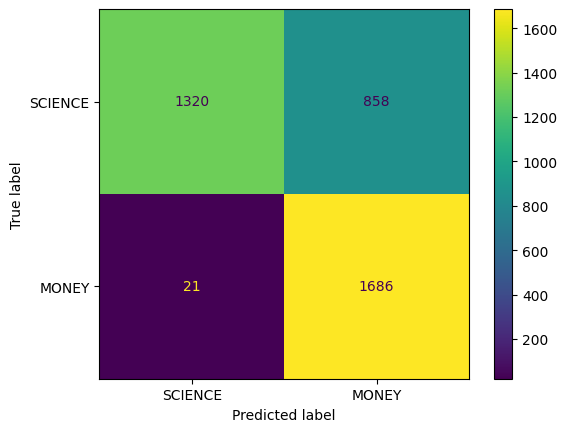

In [149]:
pred = classify_w2v(w2v_model, selected_texts[0], selected_categories=selected_categories)

print(classification_report(selected_texts[1], pred))
ConfusionMatrixDisplay(confusion_matrix(selected_texts[1], pred, labels=selected_categories), display_labels=selected_categories).plot()
plt.show()

On constate que l'on obtient de meilleures scores avec des textes normalisés. 

**f.** Veuillez réaliser une expérience de classification non supervisée sur les articles des catégories `['TECH', 'ARTS', 'COLLEGE']` en variant le paramètre `topn` de `classify_w2v` et en indiquant la meilleure valeur trouvée.

In [150]:
selected_categories = ['TECH', 'ARTS', 'COLLEGE']
selected_texts = select_texts_categories(corpus, selected_categories=selected_categories, normalize=True)

100%|██████████| 200853/200853 [00:08<00:00, 24890.63it/s]


100%|██████████| 4735/4735 [00:01<00:00, 2420.11it/s]


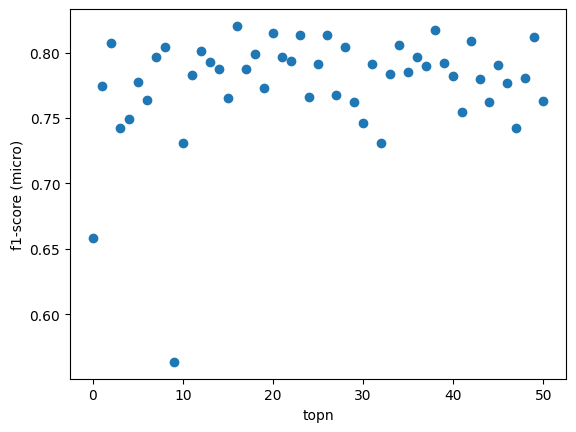

Meilleur score: 0.8204857444561774 pour topn de 16


In [151]:
topns = list(range(0, 50+1))

scores = []
for topn in topns:
    pred = classify_w2v(w2v_model, selected_texts[0], selected_categories=selected_categories, topn=topn)
    scores.append(f1_score(selected_texts[1], pred, average="micro"))

plt.scatter(topns, scores)
plt.xlabel("topn")
plt.ylabel("f1-score (micro)")
plt.show()

print(f"Meilleur score: {np.max(scores)} pour topn de {topns[np.argmax(scores)]}")

Une valeur de 16 pour _topn_ fournit le meilleur f1-score (micro) d'une valeur de ~0.82.

Voici les autres scores obtenus et la matrice de confusion associée à ce résultat:

100%|██████████| 4735/4735 [00:01<00:00, 2466.67it/s]


              precision    recall  f1-score   support

        ARTS       0.84      0.74      0.79      1509
     COLLEGE       0.78      0.83      0.80      1144
        TECH       0.83      0.88      0.85      2082

    accuracy                           0.82      4735
   macro avg       0.82      0.81      0.81      4735
weighted avg       0.82      0.82      0.82      4735



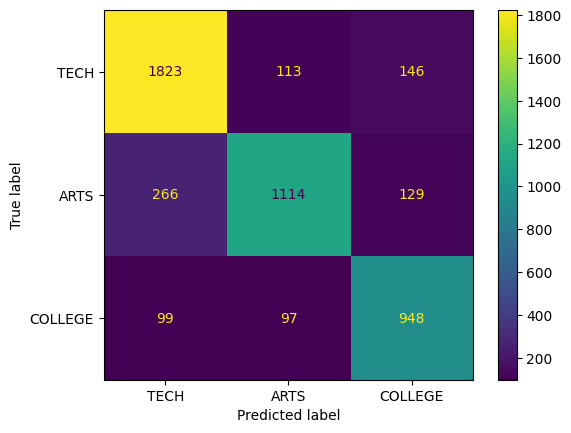

In [152]:
pred = classify_w2v(w2v_model, selected_texts[0], selected_categories=selected_categories, topn=16)

print(classification_report(selected_texts[1], pred))
ConfusionMatrixDisplay(confusion_matrix(selected_texts[1], pred, labels=selected_categories), display_labels=selected_categories).plot()
plt.show()

**g.** Veuillez comparer les deux expériences (points (e) et (f)) en termes de scores, de valeurs optimales de `topn`, et de l'impact du nettoyage de textes.   Veuillez donner votre opinion sur la qualité de la classification non supervisée avec word2vec.

**Réponse**: On obtient de meilleures scores au point (f), cela est peut-être expliqué par le fait que les mots utilisé pour la construction des vecteurs des classes utilisées n'ont pas été choisi arbitrairement contrairement aux classe _SCIENCE_ et _MONEY_, bien que les scores obtenus lors de la classification de ces deux classes sont tout de même loin d'être passables. On constate qu'au delà d'un certain seuil (~10-15), de plus grandes valeur de _topn_ ne permettent pas d'obtenir une classification significativement meilleure. Le nettoyage du texte possède un impact important sur la qualité de la classification.

En conclusion, on constate que la classification non-supervisée permet d'obtenir des résultats corrects, pas exactement parfaits mais sans doute suffisants pour de nombreux cas d'application, sans oublier la grande flexibilité proposée par cette méthode. 

**Fin du Labo.**  Veuillez nettoyer ce notebook en gardant seulement les résultats et les commentaires demandés, l'enregistrer, et le soumettre comme devoir sur Cyberlearn.